# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** xx

**Author 1 (sciper):** Julien Daniel Berger (247179)  
**Author 2 (sciper):** Ghali Chraibi (262251)   
**Author 3 (sciper):** Yasser Haddad (xxxxx)   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## Imports

In [9]:
import tarfile
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import skimage.io
import skimage.morphology
from skimage import measure, io, img_as_ubyte
from skimage.color import label2rgb, rgb2gray
from skimage.filters import gaussian, median, threshold_multiotsu, try_all_threshold

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
data_base_path = "data"
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

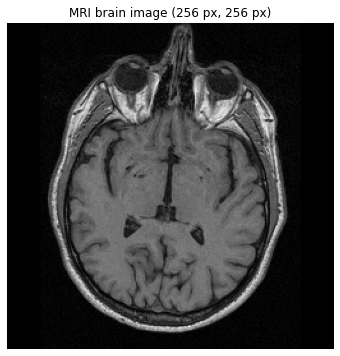

In [3]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Brain image pre-processing

but: 
- déconnecter le cerveau du reste du crane
- expliquer comment t'as trouvé le threshold
- afficher l'image median_brain

In [4]:
# Add a Gaussian blur to remove gaussian noise
gaussian_brain = cv2.GaussianBlur(brain_im,(3,3),1)

# Apply a threshold to keep only the pixels with an intensity close to the brain
thresh_brain = cv2.inRange(gaussian_brain,60,90)

# Apply a median blur to remove salt-and-pepper kind noise
median_brain = cv2.medianBlur(thresh_brain,3)

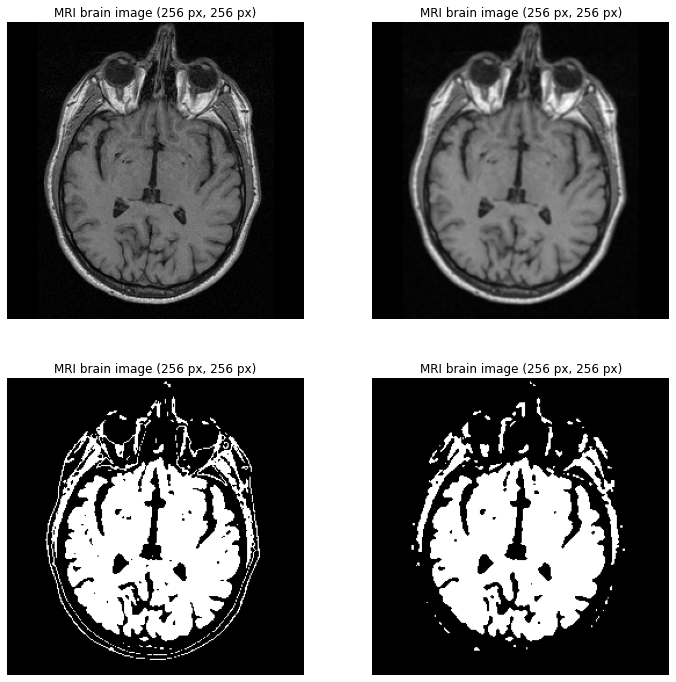

In [5]:
### Visualise the images at each step of the pre-processing
fig, ([ax1,ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(12, 12))

# Original image
ax1.imshow(brain_im, cmap='gray')
ax1.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax1.axis('off')

# Image convolved with a gaussian filter
ax2.imshow(gaussian_brain, cmap='gray')
ax2.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax2.axis('off')

# Thresholded image
ax3.imshow(thresh_brain, cmap='gray')
ax3.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax3.axis('off')

# Image convolved with a median filter
ax4.imshow(median_brain, cmap='gray')
ax4.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax4.axis('off')

plt.show()

### 1.3 Region growing (5pts)

The function used for the region growing is called measure.label(). It allows to label connected pixels. Two pixels are connected when they are neighbors and have the same value.  

In [6]:
# Label the different objects 
labeled_im = measure.label(median_brain, background=None, connectivity=median_brain.ndim)

In [7]:
print("The image is segmented into {} objects.".format(len(np.unique(labeled_im))))

The image is segmented into 57 objects.


In [10]:
# Objects smaller than 1000 pixels are removed
labeled_im = skimage.morphology.remove_small_objects(labeled_im, min_size=1000)

In [12]:
print("There are {} objects that are bigger than 1000 pixels, The backround and the brain."
      .format(len(np.unique(labeled_im))))

There are 2 objects that are bigger than 1000 pixels, The backround and the brain.


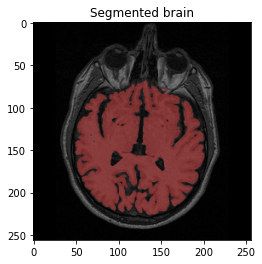

In [13]:
# Return an RGB image where color-coded labels are painted over the original image
labeled_im_color = label2rgb(labeled_im, image=brain_im, bg_label=0)
plt.imshow(labeled_im_color)
plt.title("Segmented brain");

In [22]:
# Compute the size of the labeled brain
brain_size1 = measure.regionprops_table(labeled_im, brain_im, properties=["area"])["area"][0]
print("With the region growing method, we find that the brain has a size of {} pixels".format(brain_size1))

With the region growing method, we find that the brain has a size of 15386 pixels


### 1.4 Contour detection (5pts)

In [23]:
# Find the contours of our brain image
contours, hierarchy = cv2.findContours(median_brain, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

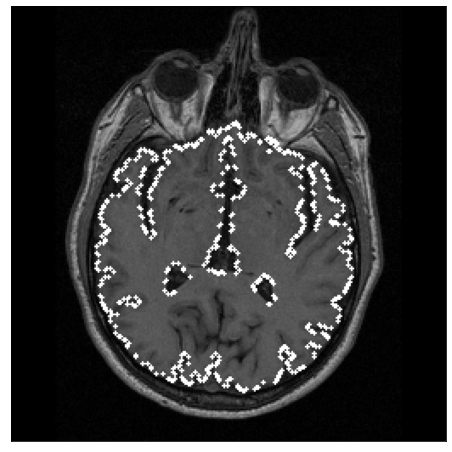

In [25]:
# Visualise the contours
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

img = cv2.drawContours(brain_im, contours[0], -1, (255,255,255), 2)
img = cv2.drawContours(img, contours[1], -1, (255,255,255), 2)
img = cv2.drawContours(img, contours[5], -1, (255,255,255), 2)
img = cv2.drawContours(img, contours[6], -1, (255,255,255), 2)

ax.imshow(img, cmap='gray')
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [29]:
# Compute the overall area of the brain in pixels
area = (cv2.contourArea(contours[0]) - cv2.contourArea(contours[1])
        - cv2.contourArea(contours[5]) - cv2.contourArea(contours[6]))

print("With the contour detection method, we find that the brain has a size of {} pixels".format(int(area)))

With the contour detection method, we find that the brain has a size of 15465 pixels


### 1.5 Additional method (5pts)

In [ ]:
# Add your implementation and discussion

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [ ]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

In [ ]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

In [ ]:
# Add your implementation and discussion

### 2.3 Total area (in pixels) of each color (5 pts)

In [ ]:
# Add your implementation and discussion